In [1375]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import math
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from pathlib import Path
import os

In [1376]:
# parent directory
parent_dir = Path.cwd().parent

# path to the dataset
train_data_path = os.path.join(parent_dir ,'data','raw','weekly-train-1.csv')
test_data_path = os.path.join(parent_dir ,'data','raw','weekly-test-1.csv')


# reading a CSV file into a DataFrame
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

df_train = df_train[df_train['TOTAL_SALES'] > 0]

df_train['set'] = 'train'
df_test['set'] = 'test'
df_test['TOTAL_SALES'] = np.nan

# concatenate for consistent feature engineering on both datasets
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [1377]:
df.sort_values(by=['PRODUCT_ID', 'DATE'], inplace=True)

In [1378]:
# creating df_test_original for presenting results later
df_test_original = df[df['set'] == 'test'].copy()
df_test_original.drop(columns=['TOTAL_SALES', 'set'], inplace=True)
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False
990,Yogurt_Greek,3450014449,2023-06-12,6.176059,False,False,True,True,False,False,False,False,False,False,False,False,False
991,Yogurt_Greek,3450014449,2023-06-19,6.175545,False,False,True,True,False,False,False,False,False,False,False,False,False
992,Yogurt_Greek,3450014449,2023-06-26,6.178684,False,False,False,False,True,False,False,False,False,False,False,False,False
993,Yogurt_Greek,3450014449,2023-07-03,6.176310,False,False,False,False,True,False,False,False,False,False,False,False,False


In [1379]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,True,False,True,False,False,False,False,False,False,False,False,False,train
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,True,False,True,False,False,False,False,False,False,False,False,False,train
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,False,False,False,False,train
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,False,False,False,False,train
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,True,False,False,False,False,False,False,False,False,False,train


In [1380]:
df.info()

<class 'pandas.DataFrame'>
Index: 1405 entries, 0 to 1404
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRODUCT_DESC          1405 non-null   str    
 1   PRODUCT_ID            1405 non-null   int64  
 2   DATE                  1405 non-null   str    
 3   TOTAL_SALES           989 non-null    float64
 4   PRICE                 1405 non-null   float64
 5   IS_COUPON             1405 non-null   bool   
 6   IS_DISPLAY            1405 non-null   bool   
 7   IS_FEATURE            1405 non-null   bool   
 8   IS_PROMO              1405 non-null   bool   
 9   IS_INDEPENDENCE_DAY   1405 non-null   bool   
 10  IS_PRE_CHRISTMAS      1405 non-null   bool   
 11  IS_SUPER_BOWL_SUNDAY  1405 non-null   bool   
 12  IS_PRE_THANKSGIVING   1405 non-null   bool   
 13  IS_EASTER_SUNDAY      1405 non-null   bool   
 14  IS_LABOR_DAY          1405 non-null   bool   
 15  IS_MEMORIAL_DAY       1405 non-null  

In [1381]:
# notice how 'tot_sales' minimum value is 0, which could be a problem for MAPE calculation
df.describe()

,PRODUCT_ID,TOTAL_SALES,PRICE
count,1.405000e+03,989.000000,1405.000000
mean,1.834992e+11,11065.805785,6.200888
std,3.244396e+11,9287.676139,1.629093
min,3.450014e+09,1628.913015,2.692734
25%,3.450015e+09,5228.798606,4.999980
50%,3.450015e+09,7633.006153,5.715059
75%,3.450015e+09,15626.911843,6.573549
max,7.677070e+11,45877.859803,10.502462


In [1382]:
df.shape

(1405, 19)

In [1383]:
# checking for missing values in the DataFrame
df.isnull().sum()

PRODUCT_DESC              0
PRODUCT_ID                0
DATE                      0
TOTAL_SALES             416
PRICE                     0
IS_COUPON                 0
IS_DISPLAY                0
IS_FEATURE                0
IS_PROMO                  0
IS_INDEPENDENCE_DAY       0
IS_PRE_CHRISTMAS          0
IS_SUPER_BOWL_SUNDAY      0
IS_PRE_THANKSGIVING       0
IS_EASTER_SUNDAY          0
IS_LABOR_DAY              0
IS_MEMORIAL_DAY           0
IS_THANKSGIVING           0
IS_CHRISTMAS_DAY          0
set                       0
dtype: int64

In [1384]:
# checking the data types of each column in the DataFrame
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

PRODUCT_DESC: str
PRODUCT_ID: int64
DATE: str
TOTAL_SALES: float64
PRICE: float64
IS_COUPON: bool
IS_DISPLAY: bool
IS_FEATURE: bool
IS_PROMO: bool
IS_INDEPENDENCE_DAY: bool
IS_PRE_CHRISTMAS: bool
IS_SUPER_BOWL_SUNDAY: bool
IS_PRE_THANKSGIVING: bool
IS_EASTER_SUNDAY: bool
IS_LABOR_DAY: bool
IS_MEMORIAL_DAY: bool
IS_THANKSGIVING: bool
IS_CHRISTMAS_DAY: bool
set: str


In [1385]:
# converting the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].dtype.name)

datetime64[us]


## Feature Engineering
Re-arranging some features in order to be able to extract useful information

### Promotion Features
Boolean features: the most important one is IS_PROMO, which indicates if there was any promotion.
IS_COUPON, IS_DISPLAY, IS_FEATURE are support variables that might increase the TOT_SALES.

Promotion features can be summarized in a PROMO_LEVEL feature, that indicates how much promoted the product in the week was. This new feature can be realized in different ways: by a naive summation of the attributes or by a weighted sum.

In [1386]:
#converting boolean values in dummy variables for promo features
df['IS_PROMO']=df['IS_PROMO'].astype(int)
df['IS_COUPON']=df['IS_COUPON'].astype(int)
df['IS_DISPLAY']=df['IS_DISPLAY'].astype(int)
df['IS_FEATURE']=df['IS_FEATURE'].astype(int)

In [1387]:
# creating a feature that indicates promotional level
# NOTICE: this can be improved, eventually considering a weighted sum based on promo supports
df['PROMO_LEVEL'] = df['IS_PROMO'] + df['IS_COUPON'] + df['IS_DISPLAY'] + df['IS_FEATURE']
df.drop(columns=['IS_PROMO', 'IS_COUPON', 'IS_DISPLAY', 'IS_FEATURE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1


### Price Feature

We need to make a difference between prices in the training and in the test set:

$$\text{Price Ratio_Training} = \frac{\text{Current Price_Training}}{\text{Average Price of this Product_Training }}$$


$$\text{Price Ratio_Test} = \frac{\text{Current Price_Test}}{\text{Average Price of this Product_Training}}$$

Consumers perceive price changes by comparing current levels with past ones.

We normalize the price relative to the historical average of the product (calculated on the training set) to provide the model with a discount signal without introducing information from the future.

In [1388]:
# calculate the mean only on training set
price_mean_train = (
    df[df["set"] == "train"]
      .groupby("PRODUCT_ID", observed=True)["PRICE"]
      .mean()
)
#map the historical average on whole dataset
df["PRICE_MEAN"] = df["PRODUCT_ID"].map(price_mean_train)
df['PRICE_RATIO'] = df['PRICE'] / df['PRICE_MEAN']

### Time Features
We need to extract information from the 'DATE' feature. Useful information might be:
- YEAR
- MONTH
- WEEK_NUM
- SEASON

#### Cyclical Encoding for Time Variables

##### 1. The Challenge: Linear Models vs. Cyclical Time
Standard machine learning models perceive numerical features linearly.
* The Issue: To a model, Month 12 (December) and Month 1 (January) are "far apart" (distance = 11).
* The Reality: In the real world, December and January are adjacent (distance = 1). The same logic applies to Weeks (Week 52 $\to$ Week 1) and Hours (23:00 $\to$ 00:00).

If we feed raw numbers (for example, 1-12) into the model, it fails to capture the continuity of the cycle, creating a "break" in the data at the end of the year.

##### 2. The Solution: Mapping to a Unit Circle
To solve this, we map our time features onto a 2D Unit Circle. Instead of a single scalar value, we represent every time point as a coordinate pair $(x, y)$ on a circle. This preserves the relative distance between points (for example, the distance between Dec 31 and Jan 1 becomes very small).

##### 3. The Transformation Formulas
We create two new features for every cyclical variable using Sine and Cosine transformations.

For a time variable $t$ with a maximum cycle length $T_{max}$ (for example, $T_{max}=12$ for months, $T_{max}=53$ for weeks):

$$
x_{sin} = \sin\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

$$
x_{cos} = \cos\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

We need both dimensions to define a unique point on the circle.
* If we only used Sine, two different points in the cycle (for example, rising in Spring vs. falling in Autumn) could have the exact same value.
* Adding Cosine breaks this symmetry, ensuring every point in time has a unique $(x, y)$ coordinate.

In [1389]:
# extracting time information from the 'DATE' column
# TO CHECK: is raw MONTH a good feature? sin and cos month?
df['MONTH'] = df['DATE'].dt.month

# TO CHECK: is WEEK_IN_MONTH a good feature? it seems a bit weak, maybe WEEM_IN_YEAR is better?
df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week

# adding YEAR as a feature, to capture potential trends over time
df['YEAR'] = df['DATE'].dt.year

# adding SEASON as a feature, to capture potential seasonal patterns
df['SEASON'] = df['MONTH'].apply(lambda x: (x%12 + 3) // 3)

df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983342,12,53,2020,1
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983170,1,1,2021,1
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983346,1,2,2021,1
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983316,1,3,2021,1
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1,5.763976,0.874479,1,4,2021,1


In [1390]:
weeks_in_year = df["WEEK_NUMBER"].max()

df["WEEK_SIN"] = np.sin(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)
df["WEEK_COS"] = np.cos(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)

In [1391]:
df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)

In [1392]:
df["SEASON_SIN"] = np.sin(2 * np.pi * df["SEASON"] / 4)
df["SEASON_COS"] = np.cos(2 * np.pi * df["SEASON"] / 4)

In [1393]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983342,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983170,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983346,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983316,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1,5.763976,0.874479,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### ID Features
PRODUCT_DESC is not useful for the purpose of predicting sales, as it's simply a human-readable label for the product. It will be later dropped.
 We can keep PRODUCT_ID, but we must consider it as a **categorical** variable, NOT AS A NUMBER! Otherwise the model might assume there's some order between IDs, which are actually simple labels. Also, 'category' type allows to save memory compared to int64 variable.

In [1394]:
df['PRODUCT_DESC'].unique()

<StringArray>
[            'Yogurt_Greek',        'Yogurt_Mini_Light',
           'Yogurt_Classic',      'Yogurt_Mini_Classic',
        'Yogurt_Mini_Greek',     'Yogurt_Giant_Classic',
 'Gold_Yogurt_Mini_Classic',   'Gold_Yogurt_Mini_Greek']
Length: 8, dtype: str

In [1395]:
# turning product_id into a categorical variable
df['PRODUCT_ID'] = df['PRODUCT_ID'].astype('category')
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983342,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983170,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983346,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983316,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1,5.763976,0.874479,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### Lag Features and Rolling Windows
When performing a regression task on time series, like this one, is also important to consider **Lag Features** and **Rolling Windows**. These artificial features give our model a sort of context, that allows it to keep track of past trends and events.

In [1396]:
# adding lag features for the target variable 'TOTAL_SALES'
# lag 52 (1 year)
df['LAG_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(52)

# rolling mean and std for the target variable 'TOTAL_SALES'
# roll 52 (1 year)
# grouping by 'PRODUCT_ID' and transforming via lamba functions to calculate rolling mean and std, shifting by 1 to avoid data leakage

df['ROLL_MEAN_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).mean())
df['ROLL_STD_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).std())

In [1397]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS,LAG_52,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983342,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2,5.763976,0.983170,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983346,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0,5.763976,0.983316,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1,5.763976,0.874479,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN


## Data Exploration
Performing some Data Exploration in order to have a visualization of our data. This can help us understand trends and distribution of sales over weeks, months and seasons.

In [1398]:
df_train = df[df['set'] == 'train'].copy()
df_test = df[df['set'] == 'test'].copy()
df_train.drop(columns=['set'], inplace=True)
df_test.drop(columns=['set'], inplace=True)

In [1399]:
df_train.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS,LAG_52,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,2,5.763976,0.983342,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,2,5.763976,0.983170,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,0,5.763976,0.983346,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,0,5.763976,0.983316,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,1,5.763976,0.874479,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17,NaN,NaN,NaN


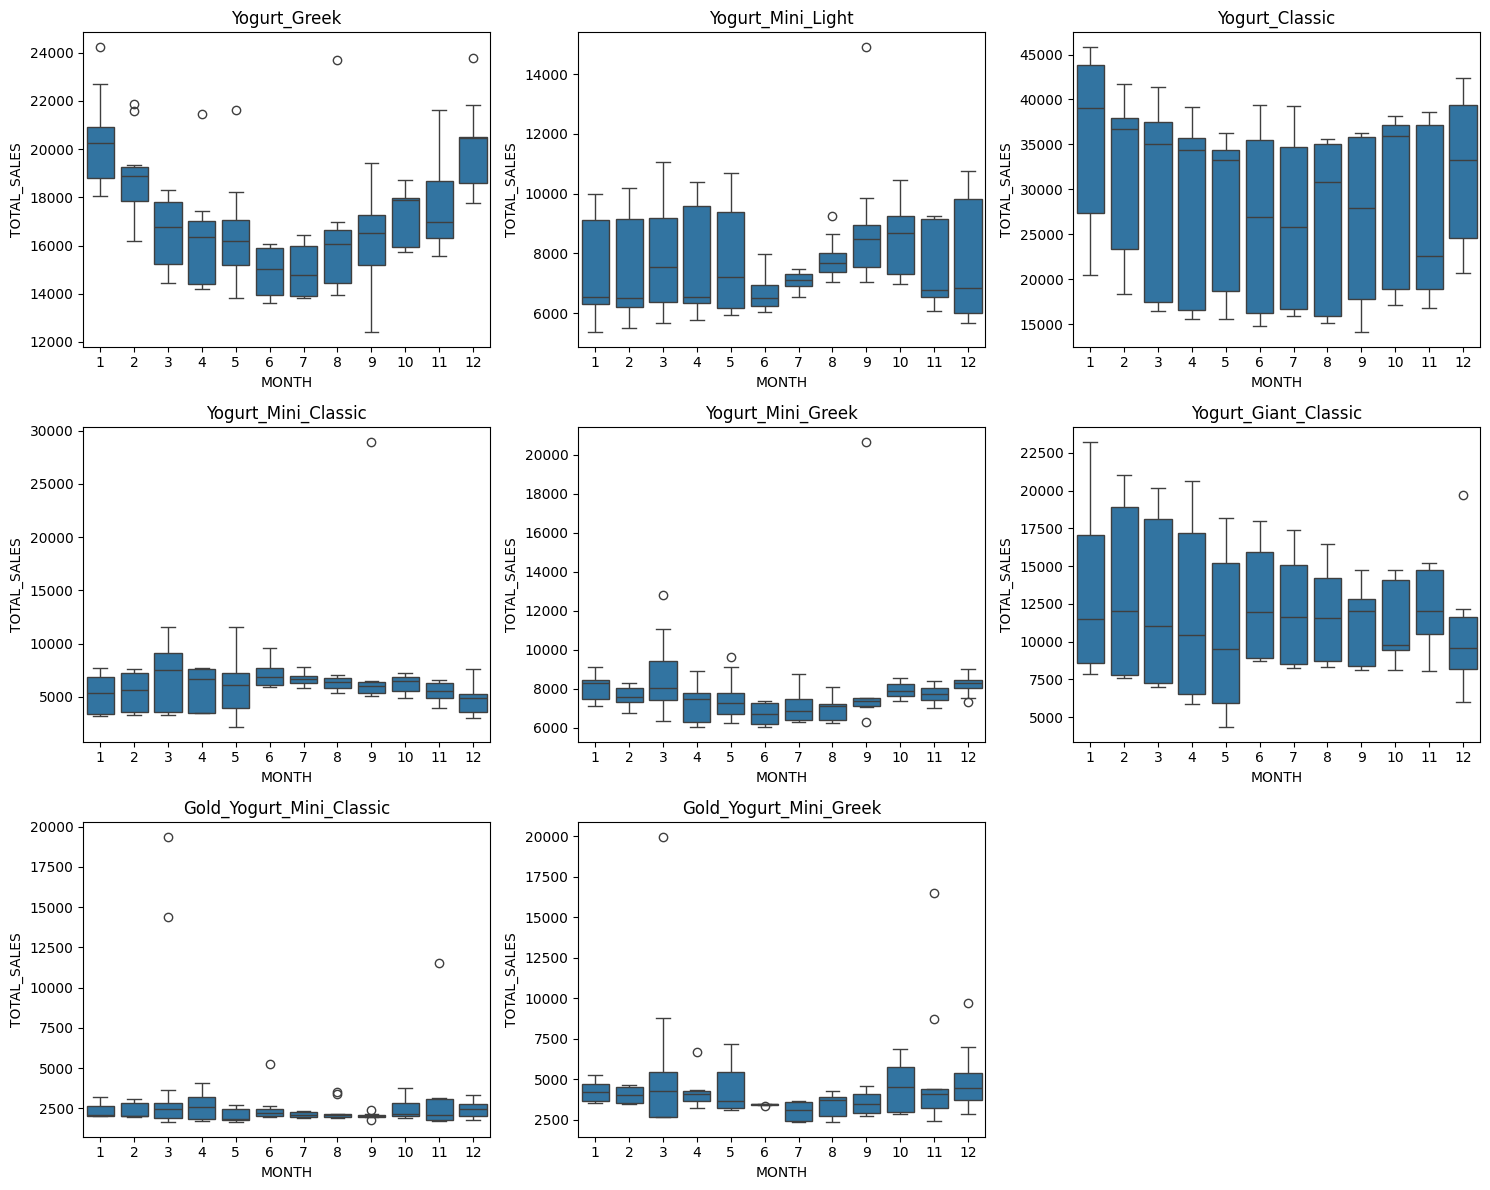

In [1400]:
# boxplot of TOTAL_SALES by MONTH for each PRODUCT_DESC
products = df_train['PRODUCT_DESC'].unique()
n_products = len(products)

n_cols = 3
n_rows = math.ceil(n_products / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='MONTH',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('MONTH')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

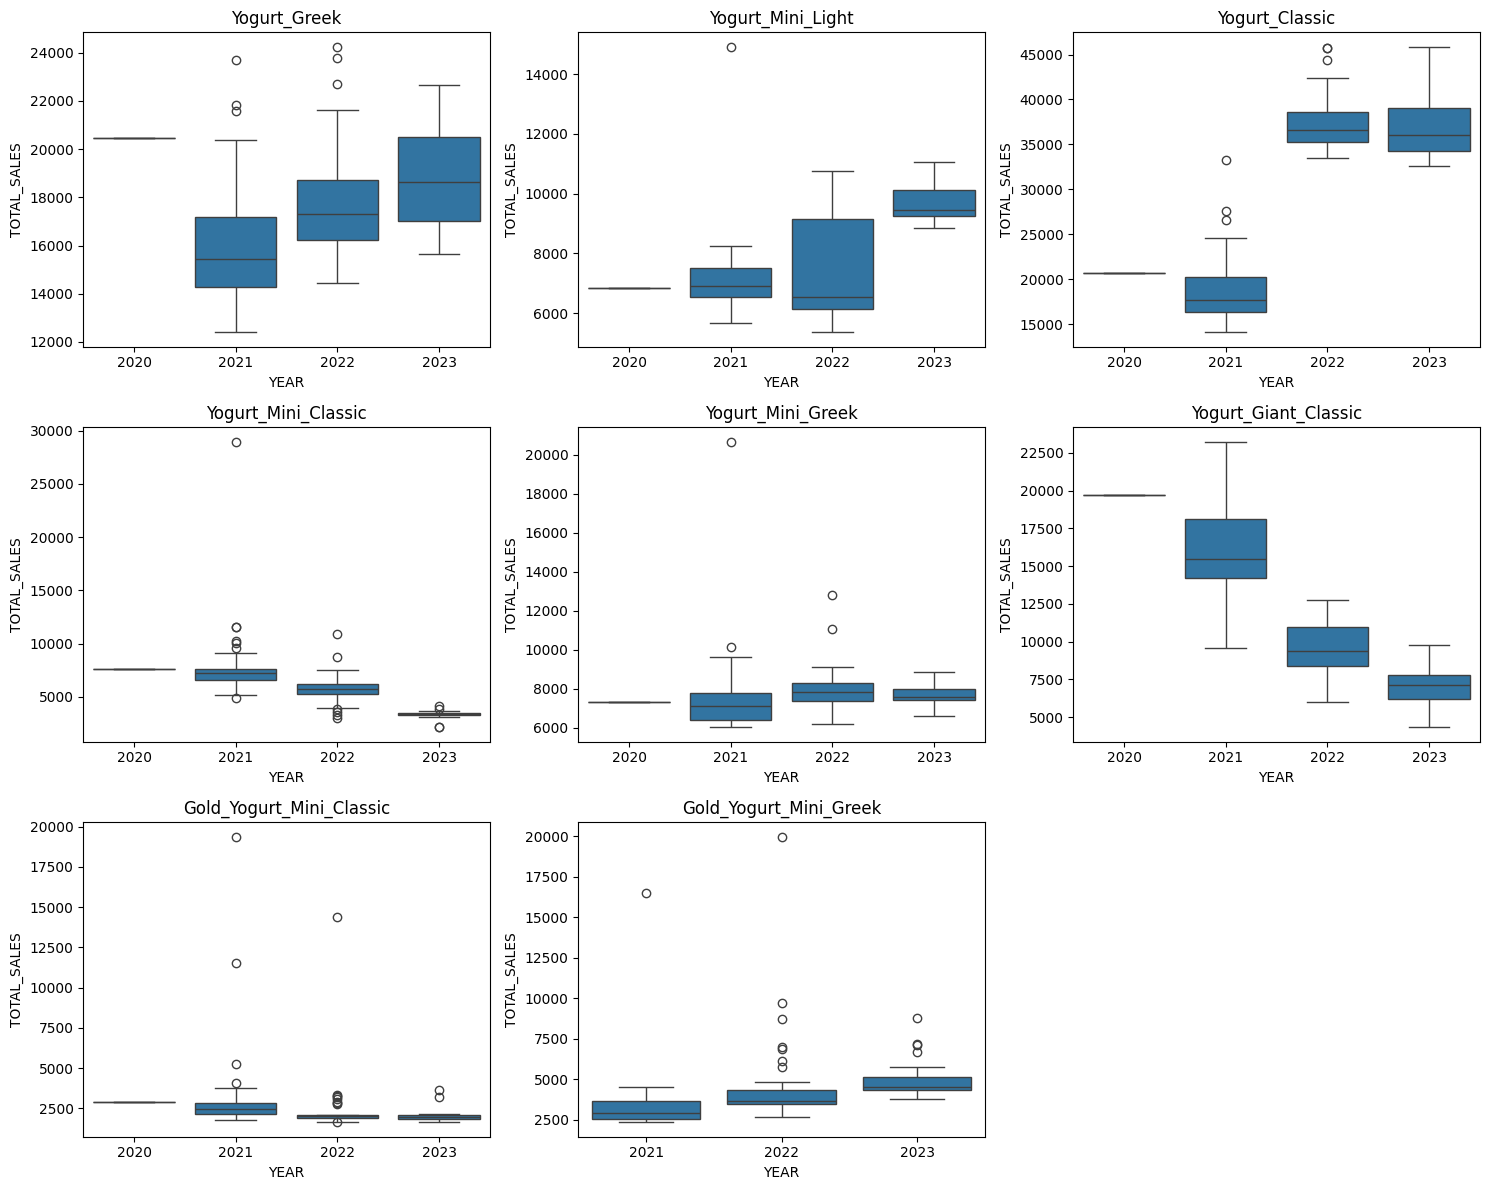

In [1401]:
# boxplot of TOTAL_SALES by YEAR for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='YEAR',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(product)
    ax.set_xlabel('YEAR')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

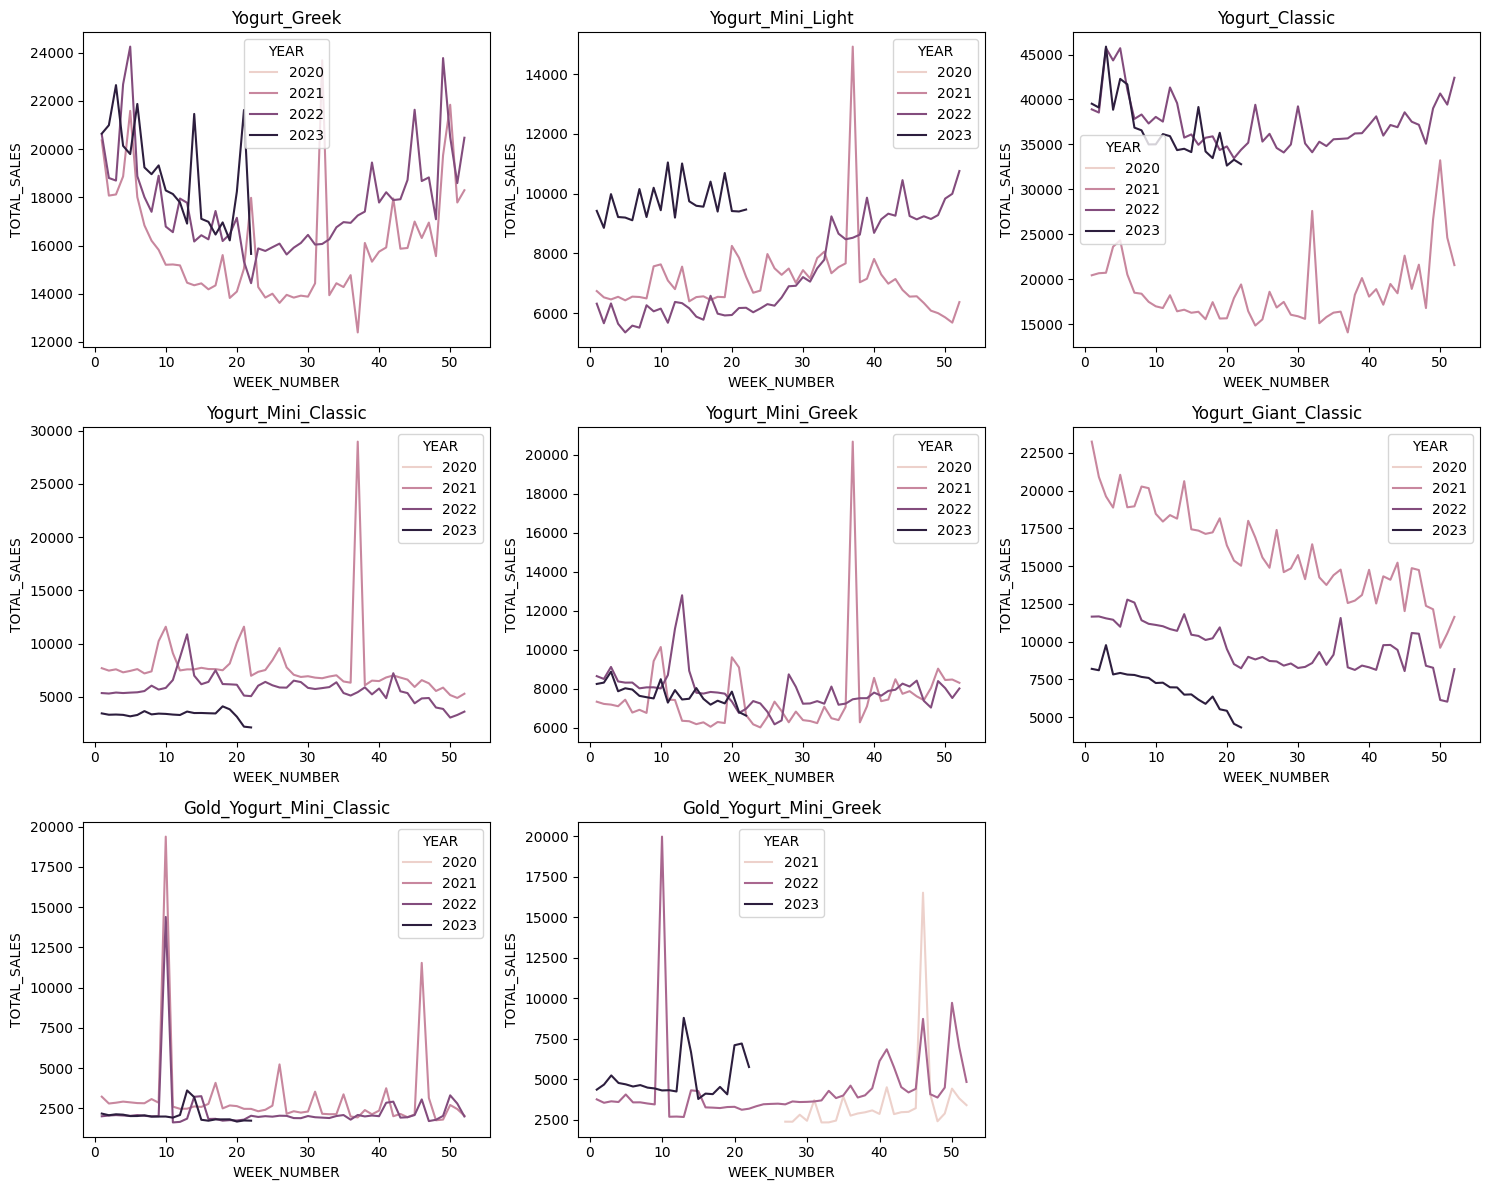

In [1402]:
# lineplot of TOTAL_SALES over time for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.lineplot(
        x='WEEK_NUMBER',
        y='TOTAL_SALES',
         hue='YEAR',
         data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('WEEK_NUMBER')
    ax.set_ylabel('TOTAL_SALES')
    ax.legend(title='YEAR')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

After plotting, since we have the transformed version of WEEK_NUMBER, MONTH, and SEASON, they are redundunt and we eliminate them.

In [1403]:
df_train.drop(columns=['DATE', 'PRODUCT_DESC', 'WEEK_NUMBER', 'MONTH', 'SEASON', 'PRICE'], inplace=True)
df_test.drop(columns=['DATE', 'PRODUCT_DESC', 'WEEK_NUMBER', 'MONTH', 'SEASON', 'TOTAL_SALES', 'PRICE'], inplace=True)

In [1404]:
df_train.info()

<class 'pandas.DataFrame'>
Index: 989 entries, 0 to 988
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PRODUCT_ID            989 non-null    category
 1   TOTAL_SALES           989 non-null    float64 
 2   IS_INDEPENDENCE_DAY   989 non-null    bool    
 3   IS_PRE_CHRISTMAS      989 non-null    bool    
 4   IS_SUPER_BOWL_SUNDAY  989 non-null    bool    
 5   IS_PRE_THANKSGIVING   989 non-null    bool    
 6   IS_EASTER_SUNDAY      989 non-null    bool    
 7   IS_LABOR_DAY          989 non-null    bool    
 8   IS_MEMORIAL_DAY       989 non-null    bool    
 9   IS_THANKSGIVING       989 non-null    bool    
 10  IS_CHRISTMAS_DAY      989 non-null    bool    
 11  PROMO_LEVEL           989 non-null    int64   
 12  PRICE_MEAN            989 non-null    float64 
 13  PRICE_RATIO           989 non-null    float64 
 14  YEAR                  989 non-null    int32   
 15  WEEK_SIN              

In [1405]:
df_train = df_train[df_train['LAG_52'].notna()].copy()

In [1406]:
df_train.head()

,PRODUCT_ID,TOTAL_SALES,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,YEAR,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS,LAG_52,ROLL_MEAN_52,ROLL_STD_52
52,3450014449,18294.990367,False,False,False,False,False,False,False,False,False,0,5.763976,0.983470,2021,-0.118273,0.992981,-2.449294e-16,1.000000,1.0,6.123234e-17,20461.337740,16066.859886,2423.677770
53,3450014449,20608.710555,False,False,False,False,False,False,False,False,False,2,5.763976,0.983224,2022,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17,20366.054602,16025.199359,2364.557701
54,3450014449,18803.285939,False,False,False,False,False,False,False,False,False,0,5.763976,0.982965,2022,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17,18072.334581,16029.865820,2373.514840
55,3450014449,18696.075088,False,False,False,False,False,False,False,False,False,0,5.763976,0.983131,2022,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17,18119.333530,16043.922577,2387.968671
56,3450014449,22693.475673,False,False,False,False,False,False,False,False,False,2,5.763976,0.861790,2022,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17,18867.597360,16055.013760,2399.110533


In [1407]:
df_test.head()

,PRODUCT_ID,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,YEAR,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS,LAG_52,ROLL_MEAN_52,ROLL_STD_52
989,3450014449,False,False,False,False,False,False,False,False,False,0,5.763976,1.071507,2023,0.403123,-0.915146,1.224647e-16,-1.000000,-1.0,-1.836970e-16,15879.049316,18200.505108,2057.691943
990,3450014449,False,False,False,False,False,False,False,False,False,2,5.763976,1.071493,2023,0.292057,-0.956401,1.224647e-16,-1.000000,-1.0,-1.836970e-16,15774.108553,NaN,NaN
991,3450014449,False,False,False,False,False,False,False,False,False,2,5.763976,1.071404,2023,0.17689,-0.984231,1.224647e-16,-1.000000,-1.0,-1.836970e-16,15929.710120,NaN,NaN
992,3450014449,True,False,False,False,False,False,False,False,False,0,5.763976,1.071948,2023,0.059241,-0.998244,1.224647e-16,-1.000000,-1.0,-1.836970e-16,16078.193544,NaN,NaN
993,3450014449,True,False,False,False,False,False,False,False,False,0,5.763976,1.071536,2023,-0.059241,-0.998244,-5.000000e-01,-0.866025,-1.0,-1.836970e-16,15626.911843,NaN,NaN


In [1408]:
df_train.info()

<class 'pandas.DataFrame'>
Index: 573 entries, 52 to 988
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PRODUCT_ID            573 non-null    category
 1   TOTAL_SALES           573 non-null    float64 
 2   IS_INDEPENDENCE_DAY   573 non-null    bool    
 3   IS_PRE_CHRISTMAS      573 non-null    bool    
 4   IS_SUPER_BOWL_SUNDAY  573 non-null    bool    
 5   IS_PRE_THANKSGIVING   573 non-null    bool    
 6   IS_EASTER_SUNDAY      573 non-null    bool    
 7   IS_LABOR_DAY          573 non-null    bool    
 8   IS_MEMORIAL_DAY       573 non-null    bool    
 9   IS_THANKSGIVING       573 non-null    bool    
 10  IS_CHRISTMAS_DAY      573 non-null    bool    
 11  PROMO_LEVEL           573 non-null    int64   
 12  PRICE_MEAN            573 non-null    float64 
 13  PRICE_RATIO           573 non-null    float64 
 14  YEAR                  573 non-null    int32   
 15  WEEK_SIN             

In [1409]:
df_test.info()

<class 'pandas.DataFrame'>
Index: 416 entries, 989 to 1404
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PRODUCT_ID            416 non-null    category
 1   IS_INDEPENDENCE_DAY   416 non-null    bool    
 2   IS_PRE_CHRISTMAS      416 non-null    bool    
 3   IS_SUPER_BOWL_SUNDAY  416 non-null    bool    
 4   IS_PRE_THANKSGIVING   416 non-null    bool    
 5   IS_EASTER_SUNDAY      416 non-null    bool    
 6   IS_LABOR_DAY          416 non-null    bool    
 7   IS_MEMORIAL_DAY       416 non-null    bool    
 8   IS_THANKSGIVING       416 non-null    bool    
 9   IS_CHRISTMAS_DAY      416 non-null    bool    
 10  PROMO_LEVEL           416 non-null    int64   
 11  PRICE_MEAN            416 non-null    float64 
 12  PRICE_RATIO           416 non-null    float64 
 13  YEAR                  416 non-null    int32   
 14  WEEK_SIN              416 non-null    Float64 
 15  WEEK_COS           

## Preparing dataset for training
Splitting the dataset into training and test dataset. Standardizing numerical feature in order to enable better performances of our regression model.

In [1410]:
X = df_train.drop(columns=['TOTAL_SALES']) # dropping non-numeric and target columns
y = df_train['TOTAL_SALES']

In [1411]:
X["YEAR"].unique()

array([2021, 2022, 2023], dtype=int32)

In [1412]:
train_mask = X["YEAR"].isin([2020, 2021, 2022])
valid_mask = X["YEAR"] == 2023

X_train = X[train_mask]
X_valid = X[valid_mask]

y_train = y[train_mask]
y_valid = y[valid_mask]

y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)

In [1413]:
X_test = df_test.copy()

In [1414]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((397, 23), (176, 23), (397,), (176,), (416, 23))

In [1415]:
X_train

,PRODUCT_ID,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,YEAR,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS,LAG_52,ROLL_MEAN_52,ROLL_STD_52
52,3450014449,False,False,False,False,False,False,False,False,False,0,5.763976,0.983470,2021,-0.118273,0.992981,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,20461.337740,16066.859886,2423.677770
53,3450014449,False,False,False,False,False,False,False,False,False,2,5.763976,0.983224,2022,0.118273,0.992981,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,20366.054602,16025.199359,2364.557701
54,3450014449,False,False,False,False,False,False,False,False,False,0,5.763976,0.982965,2022,0.234886,0.972023,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,18072.334581,16029.865820,2373.514840
55,3450014449,False,False,False,False,False,False,False,False,False,0,5.763976,0.983131,2022,0.348202,0.93742,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,18119.333530,16043.922577,2387.968671
56,3450014449,False,False,False,False,False,False,False,False,False,2,5.763976,0.861790,2022,0.456629,0.889657,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,18867.597360,16055.013760,2399.110533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,767707013501,False,True,False,False,False,False,False,False,False,0,8.985422,1.163901,2022,-0.558647,0.829406,-5.000000e-01,0.866025,-2.449294e-16,1.000000e+00,2405.175925,4190.274845,2467.639793
963,767707013501,False,False,False,False,False,False,False,False,False,0,8.985422,1.162237,2022,-0.456629,0.889657,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,2884.053275,4218.460893,2455.189365
964,767707013501,False,False,False,False,False,False,False,False,True,2,8.985422,0.830643,2022,-0.348202,0.93742,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,4421.742948,4249.262954,2448.157231
965,767707013501,False,False,False,False,False,False,False,False,True,1,8.985422,0.921267,2022,-0.234886,0.972023,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,3815.069285,4351.166966,2563.065769


In [1416]:
y_train

52      9.814437
53      9.933518
54      9.841840
55      9.836122
56     10.029877
         ...    
962     8.261488
963     8.408886
964     9.182121
965     8.850704
966     8.483657
Name: TOTAL_SALES, Length: 397, dtype: float64

## Attempt 1: LightGBM

We first tried using LightGBM, which is a lightweight version of XGBoost. 

In [1417]:
# setting up the model
lgbm_estimator = lgb.LGBMRegressor(
    objective='regression',
    metric='mape',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# defining grid
param_grid = {
    #controls complexity (lower = less overfitting and higher = more accuracy)
    'num_leaves': [31, 50],

    # step size
    'learning_rate': [0.03, 0.05],

    #trees
    'n_estimators': [1000, 2000],

    # subsampling (prevents overfitting by using part of data or features)
    'feature_fraction': [0.7, 0.8],
    'bagging_fraction': [0.7, 0.8],
    'bagging_freq': [5]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=lgbm_estimator,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1
)

# running
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

#results
print('\n')
print(f"Best MAPE: {-grid_search.best_score_:.4f}")
print("Best Parameters:", grid_search.best_params_)

# Train final model based on best parameters
best_params = grid_search.best_params_
best_model = lgb.LGBMRegressor(**best_params, objective='regression', metric='mape', random_state=42)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

Starting Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best MAPE: 0.0409
Best Parameters: {'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 31}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[760]	valid_0's mape: 0.0170288


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [1418]:
preds_log = best_model.predict(X_test)
final_preds = np.expm1(preds_log) # Reverse log with exponentiation

preds_df = pd.DataFrame(final_preds, columns=['TOTAL_SALES'])
preds_df

,TOTAL_SALES
0,17969.876496
1,4395.039324
2,4426.258547
3,3915.198381
4,4014.691035
...,...
411,2158.031957
412,1797.953731
413,2892.524369
414,2900.917378


### Bonus point in LGBM
To build a specialized model that captures Baseline Sales (organic demand) by strictly isolating natural sales patterns from marketing-driven spikes.

The "Exclusion" Approach Instead of asking the model to learn the difference between "Promo" and "Non-Promo," we simply remove all promotional weeks from the training data.

In [1419]:
# Bonus point handling

#identify rows in training set where NO promotion occurred
mask_train = X_train['PROMO_LEVEL'].eq(0)

# filter the Training Features to keep only non promo weeks
X_train = X_train.loc[mask_train]

#Align the Training Targets sales to match the filtered rows
y_train = y_train.loc[X_train.index]

# identify rows in Validation set where NO promotion occurred
mask_val = X_valid['PROMO_LEVEL'].eq(0)

# Filter the Validation set to keep only non promo weeks (for accurate scoring)
X_valid = X_valid.loc[mask_val]

# Align the Validation Targets
y_valid = y_valid.loc[X_valid.index]

# running
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

#results
print('\n')
print(f"Best MAPE: {-grid_search.best_score_:.4f}")
print("Best Parameters:", grid_search.best_params_)

# Train final model based on best parameters
best_params = grid_search.best_params_
best_model = lgb.LGBMRegressor(**best_params, objective='regression', metric='mape', random_state=42)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

# Predict baseline sales using the model trained on this pure non promo data
baseline_log = best_model.predict(X_test)

#convert the log predictions back into real unit sales
final_baseline_lgbm = np.expm1(baseline_log)

Starting Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best MAPE: 0.0419
Best Parameters: {'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'n_estimators': 2000, 'num_leaves': 31}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1294]	valid_0's mape: 0.0191778


Results are pretty good. What if we try using a more powerful model?

## Our model: XGBoost
We're gonna now try using XGBoost for this regression task. 

In [1422]:
# creating model
base_est = xgb.XGBRegressor(tree_method='hist', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}


gscv = GridSearchCV(estimator=base_est,
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_percentage_error', # using negative MAPE as scoring metric
                    cv=tscv,
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_params)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 700, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
Best score:  0.03702446675523846


In [1423]:
# assessing model performance on the validation set
y_pred = xbm.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)
print(f"MAPE on validation set: {mape}")

MAPE on validation set: 0.016775469377477918


Predictions on the test set

In [1424]:
preds_log = xbm.predict(X_test)
final_preds = np.expm1(preds_log) # Reverse log with exponentiation

In [1425]:
# adding predictions to the test set
df_test_original['TOTAL_SALES_PRED'] = final_preds
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,TOTAL_SALES_PRED
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False,18982.328125
990,Yogurt_Greek,3450014449,2023-06-12,6.176059,False,False,True,True,False,False,False,False,False,False,False,False,False,34499.414062
991,Yogurt_Greek,3450014449,2023-06-19,6.175545,False,False,True,True,False,False,False,False,False,False,False,False,False,34593.414062
992,Yogurt_Greek,3450014449,2023-06-26,6.178684,False,False,False,False,True,False,False,False,False,False,False,False,False,34508.957031
993,Yogurt_Greek,3450014449,2023-07-03,6.176310,False,False,False,False,True,False,False,False,False,False,False,False,False,34201.203125


### Baseline predictions

In [1426]:

#identify rows in training set where NO promotion occurred
mask_train = X_train['PROMO_LEVEL'].eq(0)

# filter the Training Features to keep only non promo weeks
X_train = X_train.loc[mask_train]

#Align the Training Targets sales to match the filtered rows
y_train = y_train.loc[X_train.index]

# identify rows in Validation set where NO promotion occurred
mask_val = X_valid['PROMO_LEVEL'].eq(0)

# Filter the Validation set to keep only non promo weeks (for accurate scoring)
X_valid = X_valid.loc[mask_val]

# Align the Validation Targets
y_valid = y_valid.loc[X_valid.index]

In [1427]:
# creating model
base_est_baseline = xgb.XGBRegressor(tree_method='hist', random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}

gscv = GridSearchCV(estimator=base_est_baseline,
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_percentage_error', # using negative MAPE as scoring metric
                    cv=tscv,
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm_baseline, xbm_baseline_params = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_baseline_params)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 700, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
Best score:  0.03702446675523846


In [1428]:
# assessing model performance on the validation set
y_pred = xbm_baseline.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)
print(f"MAPE on validation set: {mape}")

MAPE on validation set: 0.016775469377477918


Predictions for the baseline

In [1429]:
# Predict baseline sales using the model trained on this pure non promo data
baseline_log = xbm_baseline.predict(X_test)

#convert the log predictions back into real unit sales
final_baseline = np.expm1(baseline_log)

In [1430]:
# add baseline predictions to the test set
df_test_original['BASELINE_PRED'] = final_baseline_lgbm
df_test_original.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,TOTAL_SALES_PRED,BASELINE_PRED
989,Yogurt_Greek,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,False,False,False,False,False,False,18982.328125,19141.411502
990,Yogurt_Greek,3450014449,2023-06-12,6.176059,False,False,True,True,False,False,False,False,False,False,False,False,False,34499.414062,3641.422722
991,Yogurt_Greek,3450014449,2023-06-19,6.175545,False,False,True,True,False,False,False,False,False,False,False,False,False,34593.414062,3656.381789
992,Yogurt_Greek,3450014449,2023-06-26,6.178684,False,False,False,False,True,False,False,False,False,False,False,False,False,34508.957031,3649.873418
993,Yogurt_Greek,3450014449,2023-07-03,6.176310,False,False,False,False,True,False,False,False,False,False,False,False,False,34201.203125,3657.929522


In [1431]:
# saving results as csv file
output_path = os.path.join(parent_dir, 'data', 'processed', 'test_predictions.csv')
df_test_original.to_csv(output_path, index=False)